In [1]:
import torch 
from torch import nn
import torchvision
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Compose

class ImageDataset(Dataset):
    def __init__(self, image_dir, image_dir_2, transform=None):
        self.image_dir = image_dir
        self.image_dir_2 = image_dir_2
        self.image_files = [i for i in os.listdir(image_dir) if i.endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        self.images_files_2 = [i for i in os.listdir(image_dir_2) if i.endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        self.transform = transform
 
    def len(self):
        return len(self.image_files)

    def getItem(self, dirc, files, idx):
        img_path = os.path.join(dirc, files[idx])
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image  
    
    def getDataset(self, limit):
        total_dataset = []
        for i in range(limit):
            if i % 1000 == 0:
                print(f"Have reached {i}/{len(self.image_files)}")
            total_dataset.append([self.getItem(dirc =self.image_dir, files=self.image_files, idx=i), self.getItem(dirc =self.image_dir_2, files=self.images_files_2, idx=i)])
        return total_dataset

In [4]:
from dotenv import load_dotenv
import os

load_dotenv()
clean_dir = os.environ["DATA_DIR"]
noise_dir = os.environ['DATA_DIR_2']

In [5]:
transformations = Compose([
    ToTensor(), 
])

train_dataset = ImageDataset(image_dir=clean_dir, image_dir_2=noise_dir, transform=transformations).getDataset(7000)
test_dataset = ImageDataset(image_dir=clean_dir, image_dir_2=noise_dir, transform=transformations).getDataset(2000)

Have reached 0/31500
Have reached 1000/31500
Have reached 2000/31500
Have reached 3000/31500
Have reached 4000/31500
Have reached 5000/31500
Have reached 6000/31500
Have reached 0/31500
Have reached 1000/31500


In [6]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [7]:
train_image_batches, train_target_batches = next(iter(train_dataloader))

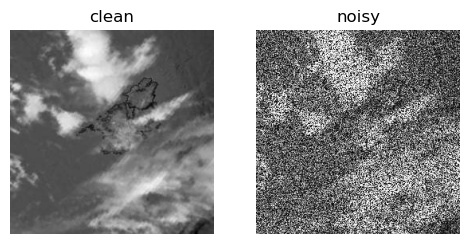

In [8]:
import matplotlib.pyplot as plt

rand = torch.randint(low=1, high=32, size=(1,)).item()
test_image = train_image_batches[rand]
test_target = train_target_batches[rand]

plt.figure(figsize=(9,9))
plt.subplot(3,3, 1)
plt.imshow(test_image.squeeze(), cmap='gray')
plt.title('clean')
plt.axis(False)
plt.subplot(3,3,2)
plt.imshow(test_target.squeeze(), cmap='gray')
plt.title('noisy')
plt.axis(False)
plt.show()


In [13]:
class SARDespeckleModel(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()
        self.initial_stack = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU()
        )
        self.middle_stack = nn.Sequential(
            *[
                nn.Sequential(
                    nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
                    nn.BatchNorm2d(num_features=hidden_units),
                    nn.ReLU()
                )
                for _ in range(6)
            ]
        )
        self.final_stack = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=output_shape, kernel_size=3, stride=1, padding=0),
            nn.ReLU()
        )
    
    def forward(self, initial:torch.Tensor):
        x = self.initial_stack(initial)
        x = self.middle_stack(x)
        res = self.final_stack(x)
        despeckle = initial/(res + 1e-8)
        img = nn.Tanh(despeckle)
        return img

In [15]:
model0 = SARDespeckleModel(
    input_shape=1,
    hidden_units=64,
    output_shape=1,
)
model0

SARDespeckleModel(
  (initial_stack): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (middle_stack): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): Sequential(
      (0): Conv2d(64, 64, kernel_

In [16]:
# import torchmetrics
# from torchmetrics.image import TotalVariation

# def loss_fn(img, ):
#     euc = torch.sqrt((x - y)**2).sum()

mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(params=model0.parameters(), lr=0.001)

In [18]:
model0.state_dict()

OrderedDict([('initial_stack.0.weight',
              tensor([[[[ 0.2837, -0.1631, -0.0477],
                        [-0.1021, -0.1749,  0.2901],
                        [ 0.0535,  0.1834, -0.1801]]],
              
              
                      [[[-0.2975, -0.0085, -0.1366],
                        [-0.2333, -0.2968, -0.2670],
                        [-0.0864,  0.2810,  0.2376]]],
              
              
                      [[[ 0.0262,  0.1792,  0.3019],
                        [ 0.1113, -0.0327, -0.2396],
                        [ 0.2504, -0.1570,  0.1987]]],
              
              
                      [[[ 0.2040, -0.2668,  0.2715],
                        [ 0.2979,  0.2536,  0.1909],
                        [-0.0734, -0.3146, -0.2927]]],
              
              
                      [[[-0.0655, -0.1044,  0.2600],
                        [ 0.1980, -0.3066,  0.1386],
                        [ 0.2533, -0.2999, -0.1804]]],
              
              
     

In [ ]:
from tqdm.auto import tqdm

EPOCHS = 3

for epoch in tqdm(EPOCHS):
    